# 数据预处理

In [1]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers.legacy import Adam
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [174]:
df = pd.read_csv('/Users/harvey/Desktop/quant2/FE/final_data_20240303.csv')

In [175]:
# 找到第一个空值出现的位置
first_null_position = df.isnull().any(axis=1).idxmin()

In [176]:
df = df[first_null_position:]

In [177]:
df = df.set_index('Date')

In [178]:
df.isnull().values.any()

False

# 普通预测

In [66]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 假设 df 是您的 DataFrame

# 数据准备
features = df.drop(['close', 'time', 'open', 'high', 'low'], axis=1)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_label = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_label.fit_transform(df[['close']])
scaled_features = np.hstack((scaled_features, scaled_close))


time_step=96*3

future_step=12

from keras import backend as K




# 修改create_dataset以预测未来48个数据点
def create_dataset(data, time_step, future_step):
    X, Y = [], []
    for i in range(len(data) - time_step - future_step):
        a = data[i:(i + time_step), :-1]  # 特征
        X.append(a)
        Y.append(data[(i + time_step):(i + time_step + future_step), -1])  # 'close'列的未来48个数据点
    return np.array(X), np.array(Y)

# 应用修改后的时间步长
X, y = create_dataset(scaled_features, time_step=time_step, future_step=future_step)

# 划分训练集和测试集
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer='glorot_uniform'),
    LSTM(50, return_sequences=False),
    Dense(future_step)
])

# 定义自定义损失函数
def custom_loss(y_true, y_pred):
    y_pred_last = y_pred[:, -1]
    y_true_last = y_true[:, -1]
    return K.mean(K.square(y_pred_last - y_true_last), axis=-1)


def custom_loss(y_true, y_pred):
    weights = K.arange(1, K.shape(y_true)[-1] + 1, dtype=K.floatx())  # 加权因子
    mse = K.square(y_pred - y_true)
    weighted_mse = mse * weights  # 加权均方误差
    return K.mean(weighted_mse, axis=-1)

optimizer = Adam(learning_rate=0.001, clipvalue=0.5)  # clipvalue是梯度裁剪的阈值
model.compile(optimizer=optimizer,loss=custom_loss)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, verbose=1)

# 预测和可视化
y_pred = model.predict(X_test)




Epoch 1/10
18/96 [====>.........................] - ETA: 10s - loss: 0.5967

KeyboardInterrupt: 

In [ ]:
y_pred_rescaled = scaler_label.inverse_transform(y_pred)
y_test_rescaled = scaler_label.inverse_transform(y_test)
plt.plot(y_pred_rescaled[:,-1],label='pred')
plt.plot(y_test_rescaled[:,-1],label='test')

plt.legend()

# 滚动窗口预测

In [82]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 假设 df 是您的 DataFrame

# 数据准备
features = df.drop(['close', 'time', 'open', 'high', 'low'], axis=1)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_label = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_label.fit_transform(df[['close']])
scaled_features = np.hstack((scaled_features, scaled_close))


time_step=96*3

future_step=12

from keras import backend as K



# 修改create_dataset函数，以支持滚动预测
def create_dataset(data, start_index, end_index, time_step, future_step):
    X, Y = [], []
    if end_index is None:
        end_index = len(data) - future_step
    for i in range(start_index, end_index):
        end_ix = i + time_step
        out_end_ix = end_ix + future_step
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix:out_end_ix, -1]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

# 初始化模型结构
def build_model(input_shape, output_units):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape, kernel_initializer='glorot_uniform'),
        LSTM(50),
        Dense(output_units)
    ])
    return model


# 自定义加权损失函数
def custom_loss(y_true, y_pred):
    weights = K.arange(1, K.shape(y_true)[-1] + 1, dtype=K.floatx())
    mse = K.square(y_pred - y_true)
    weighted_mse = mse * weights
    return K.mean(weighted_mse, axis=-1)

# 滚动预测
predictions = []
n_records = len(scaled_features)
for i in range(0, n_records - time_step, future_step):
    print(f"Processing window: {i} to {i+time_step}")
    X_train, y_train = create_dataset(scaled_features, i, i+time_step, time_step, future_step)
    
    # 仅当有足够的数据训练时
    if len(X_train) > 0:
        model = build_model(X_train.shape[1:], future_step)
        optimizer = Adam(learning_rate=0.001, clipvalue=0.5)
        model.compile(optimizer=optimizer, loss=custom_loss)
        model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1)
        
        # 预测未来数据点
        X_pred, _ = create_dataset(scaled_features, i+time_step, i+time_step+future_step, time_step, future_step)
        if len(X_pred) > 0:
            y_pred = model.predict(X_pred)
            predictions.append(y_pred)

# 预测和可视化




Processing window: 0 to 288
Epoch 1/5
5/5 [==============================] - 2s 116ms/step - loss: 0.0351
Epoch 2/5
5/5 [==============================] - 1s 124ms/step - loss: 0.0110
Epoch 3/5
5/5 [==============================] - 1s 118ms/step - loss: 0.0081
Epoch 4/5
5/5 [==============================] - 1s 112ms/step - loss: 0.0050
Epoch 5/5
1/1 [==============================] - 0s 277ms/step
Processing window: 12 to 300
Epoch 1/5
5/5 [==============================] - 2s 120ms/step - loss: 0.0341
Epoch 2/5
5/5 [==============================] - 1s 116ms/step - loss: 0.0130
Epoch 3/5
5/5 [==============================] - 1s 116ms/step - loss: 0.0058
Epoch 4/5
5/5 [==============================] - 1s 122ms/step - loss: 0.0049
Epoch 5/5
1/1 [==============================] - 0s 271ms/step
Processing window: 24 to 312
Epoch 1/5
5/5 [==============================] - 2s 117ms/step - loss: 0.0789
Epoch 2/5
5/5 [==============================] - 1s 122ms/step - loss: 0.0239
Epoch 3/

5/5 [==============================] - 1s 113ms/step - loss: 0.0194
Epoch 3/5
5/5 [==============================] - 1s 112ms/step - loss: 0.0085
Epoch 4/5
5/5 [==============================] - 1s 111ms/step - loss: 0.0059
Epoch 5/5
1/1 [==============================] - 0s 261ms/step
Processing window: 216 to 504
Epoch 1/5
5/5 [==============================] - 2s 112ms/step - loss: 0.0401
Epoch 2/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0162
Epoch 3/5
5/5 [==============================] - 1s 122ms/step - loss: 0.0059
Epoch 4/5
5/5 [==============================] - 1s 118ms/step - loss: 0.0058
Epoch 5/5
1/1 [==============================] - 0s 273ms/step
Processing window: 228 to 516
Epoch 1/5
5/5 [==============================] - 2s 116ms/step - loss: 0.0275
Epoch 2/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0091
Epoch 3/5
5/5 [==============================] - 1s 112ms/step - loss: 0.0065
Epoch 4/5
5/5 [=============================

5/5 [==============================] - 1s 115ms/step - loss: 0.0177
Epoch 5/5
1/1 [==============================] - 0s 259ms/step
Processing window: 420 to 708
Epoch 1/5
5/5 [==============================] - 2s 122ms/step - loss: 0.0848
Epoch 2/5
5/5 [==============================] - 1s 124ms/step - loss: 0.0307
Epoch 3/5
5/5 [==============================] - 1s 122ms/step - loss: 0.0104
Epoch 4/5
5/5 [==============================] - 1s 121ms/step - loss: 0.0095
Epoch 5/5
1/1 [==============================] - 0s 256ms/step
Processing window: 432 to 720
Epoch 1/5
5/5 [==============================] - 2s 116ms/step - loss: 0.1495
Epoch 2/5
5/5 [==============================] - 1s 114ms/step - loss: 0.0540
Epoch 3/5
5/5 [==============================] - 1s 118ms/step - loss: 0.0264
Epoch 4/5
5/5 [==============================] - 1s 124ms/step - loss: 0.0224
Epoch 5/5
1/1 [==============================] - 0s 265ms/step
Processing window: 444 to 732
Epoch 1/5
5/5 [==============

1/1 [==============================] - 0s 285ms/step
Processing window: 624 to 912
Epoch 1/5
5/5 [==============================] - 2s 113ms/step - loss: 0.1574
Epoch 2/5
5/5 [==============================] - 1s 112ms/step - loss: 0.0343
Epoch 3/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0167
Epoch 4/5
5/5 [==============================] - 1s 111ms/step - loss: 0.0098
Epoch 5/5
1/1 [==============================] - 0s 265ms/step
Processing window: 636 to 924
Epoch 1/5
5/5 [==============================] - 2s 112ms/step - loss: 0.1120
Epoch 2/5
5/5 [==============================] - 1s 116ms/step - loss: 0.0238
Epoch 3/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0099
Epoch 4/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0108
Epoch 5/5
1/1 [==============================] - 0s 270ms/step
Processing window: 648 to 936
Epoch 1/5
5/5 [==============================] - 2s 115ms/step - loss: 0.2011
Epoch 2/5
5/5 [==============

5/5 [==============================] - 2s 127ms/step - loss: 0.3480
Epoch 2/5
5/5 [==============================] - 1s 120ms/step - loss: 0.0795
Epoch 3/5
5/5 [==============================] - 1s 114ms/step - loss: 0.0321
Epoch 4/5
5/5 [==============================] - 1s 128ms/step - loss: 0.0201
Epoch 5/5
1/1 [==============================] - 0s 265ms/step
Processing window: 840 to 1128
Epoch 1/5
5/5 [==============================] - 2s 114ms/step - loss: 0.3110
Epoch 2/5
5/5 [==============================] - 1s 112ms/step - loss: 0.0679
Epoch 3/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0230
Epoch 4/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0170
Epoch 5/5
1/1 [==============================] - 0s 260ms/step
Processing window: 852 to 1140
Epoch 1/5
5/5 [==============================] - 2s 112ms/step - loss: 0.2853
Epoch 2/5
5/5 [==============================] - 1s 111ms/step - loss: 0.0463
Epoch 3/5
5/5 [===========================

5/5 [==============================] - 1s 121ms/step - loss: 0.0524
Epoch 3/5
5/5 [==============================] - 1s 119ms/step - loss: 0.0292
Epoch 4/5
5/5 [==============================] - 1s 125ms/step - loss: 0.0163
Epoch 5/5
1/1 [==============================] - 0s 292ms/step
Processing window: 1044 to 1332
Epoch 1/5
5/5 [==============================] - 2s 114ms/step - loss: 0.4225
Epoch 2/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0710
Epoch 3/5
5/5 [==============================] - 1s 114ms/step - loss: 0.0393
Epoch 4/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0192
Epoch 5/5
1/1 [==============================] - 0s 271ms/step
Processing window: 1056 to 1344
Epoch 1/5
5/5 [==============================] - 2s 114ms/step - loss: 0.3583
Epoch 2/5
5/5 [==============================] - 1s 117ms/step - loss: 0.0529
Epoch 3/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0285
Epoch 4/5
5/5 [=========================

5/5 [==============================] - 1s 116ms/step - loss: 0.0361
Epoch 4/5
5/5 [==============================] - 1s 117ms/step - loss: 0.0173
Epoch 5/5
1/1 [==============================] - 0s 274ms/step
Processing window: 1248 to 1536
Epoch 1/5
5/5 [==============================] - 2s 121ms/step - loss: 0.3047
Epoch 2/5
5/5 [==============================] - 1s 118ms/step - loss: 0.0742
Epoch 3/5
5/5 [==============================] - 1s 123ms/step - loss: 0.0241
Epoch 4/5
5/5 [==============================] - 1s 120ms/step - loss: 0.0204
Epoch 5/5
1/1 [==============================] - 0s 291ms/step
Processing window: 1260 to 1548
Epoch 1/5
5/5 [==============================] - 2s 117ms/step - loss: 0.3809
Epoch 2/5
5/5 [==============================] - 1s 127ms/step - loss: 0.0438
Epoch 3/5
5/5 [==============================] - 1s 117ms/step - loss: 0.0449
Epoch 4/5
5/5 [==============================] - 1s 116ms/step - loss: 0.0125
Epoch 5/5
1/1 [=========================

5/5 [==============================] - 1s 126ms/step - loss: 0.0131
Epoch 5/5
1/1 [==============================] - 0s 281ms/step
Processing window: 1452 to 1740
Epoch 1/5
5/5 [==============================] - 2s 121ms/step - loss: 0.2152
Epoch 2/5
5/5 [==============================] - 1s 120ms/step - loss: 0.0306
Epoch 3/5
5/5 [==============================] - 1s 127ms/step - loss: 0.0229
Epoch 4/5
5/5 [==============================] - 1s 118ms/step - loss: 0.0138
Epoch 5/5
1/1 [==============================] - 0s 279ms/step
Processing window: 1464 to 1752
Epoch 1/5
5/5 [==============================] - 2s 123ms/step - loss: 0.3569
Epoch 2/5
5/5 [==============================] - 1s 123ms/step - loss: 0.0601
Epoch 3/5
5/5 [==============================] - 1s 122ms/step - loss: 0.0311
Epoch 4/5
5/5 [==============================] - 1s 122ms/step - loss: 0.0171
Epoch 5/5
1/1 [==============================] - 0s 272ms/step
Processing window: 1476 to 1764
Epoch 1/5
5/5 [========

1/1 [==============================] - 0s 267ms/step
Processing window: 1656 to 1944
Epoch 1/5
5/5 [==============================] - 2s 117ms/step - loss: 0.4105
Epoch 2/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0698
Epoch 3/5
5/5 [==============================] - 1s 114ms/step - loss: 0.0340
Epoch 4/5
5/5 [==============================] - 1s 114ms/step - loss: 0.0238
Epoch 5/5
1/1 [==============================] - 0s 277ms/step
Processing window: 1668 to 1956
Epoch 1/5
5/5 [==============================] - 2s 114ms/step - loss: 0.3176
Epoch 2/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0682
Epoch 3/5
5/5 [==============================] - 1s 116ms/step - loss: 0.0337
Epoch 4/5
5/5 [==============================] - 1s 116ms/step - loss: 0.0320
Epoch 5/5
1/1 [==============================] - 0s 281ms/step
Processing window: 1680 to 1968
Epoch 1/5
5/5 [==============================] - 2s 121ms/step - loss: 0.3394
Epoch 2/5
5/5 [========

Processing window: 1860 to 2148
Epoch 1/5
5/5 [==============================] - 2s 115ms/step - loss: 0.6960
Epoch 2/5
5/5 [==============================] - 1s 113ms/step - loss: 0.1405
Epoch 3/5
5/5 [==============================] - 1s 117ms/step - loss: 0.0622
Epoch 4/5
5/5 [==============================] - 1s 114ms/step - loss: 0.0345
Epoch 5/5
1/1 [==============================] - 0s 279ms/step
Processing window: 1872 to 2160
Epoch 1/5
5/5 [==============================] - 2s 114ms/step - loss: 0.8431
Epoch 2/5
5/5 [==============================] - 1s 120ms/step - loss: 0.1139
Epoch 3/5
5/5 [==============================] - 1s 114ms/step - loss: 0.0665
Epoch 4/5
5/5 [==============================] - 1s 114ms/step - loss: 0.0404
Epoch 5/5
1/1 [==============================] - 0s 268ms/step
Processing window: 1884 to 2172
Epoch 1/5
5/5 [==============================] - 2s 117ms/step - loss: 0.3507
Epoch 2/5
5/5 [==============================] - 1s 118ms/step - loss: 0.060

5/5 [==============================] - 1s 119ms/step - loss: 0.1052
Epoch 3/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0846
Epoch 4/5
5/5 [==============================] - 1s 114ms/step - loss: 0.0190
Epoch 5/5
1/1 [==============================] - 0s 271ms/step
Processing window: 2076 to 2364
Epoch 1/5
5/5 [==============================] - 2s 115ms/step - loss: 1.4199
Epoch 2/5
5/5 [==============================] - 1s 112ms/step - loss: 0.3382
Epoch 3/5
5/5 [==============================] - 1s 112ms/step - loss: 0.1061
Epoch 4/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0373
Epoch 5/5
1/1 [==============================] - 0s 267ms/step
Processing window: 2088 to 2376
Epoch 1/5
5/5 [==============================] - 2s 114ms/step - loss: 1.1111
Epoch 2/5
5/5 [==============================] - 1s 114ms/step - loss: 0.1497
Epoch 3/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0718
Epoch 4/5
5/5 [=========================

5/5 [==============================] - 1s 111ms/step - loss: 0.1213
Epoch 4/5
5/5 [==============================] - 1s 112ms/step - loss: 0.0623
Epoch 5/5
1/1 [==============================] - 0s 262ms/step
Processing window: 2280 to 2568
Epoch 1/5
5/5 [==============================] - 2s 110ms/step - loss: 1.6243
Epoch 2/5
5/5 [==============================] - 1s 112ms/step - loss: 0.3777
Epoch 3/5
5/5 [==============================] - 1s 110ms/step - loss: 0.0957
Epoch 4/5
5/5 [==============================] - 1s 111ms/step - loss: 0.0765
Epoch 5/5
1/1 [==============================] - 0s 261ms/step
Processing window: 2292 to 2580
Epoch 1/5
5/5 [==============================] - 2s 112ms/step - loss: 1.4345
Epoch 2/5
5/5 [==============================] - 1s 138ms/step - loss: 0.1745
Epoch 3/5
5/5 [==============================] - 1s 116ms/step - loss: 0.0739
Epoch 4/5
5/5 [==============================] - 1s 117ms/step - loss: 0.0602
Epoch 5/5
1/1 [=========================

5/5 [==============================] - 1s 116ms/step - loss: 0.0658
Epoch 5/5
1/1 [==============================] - 0s 281ms/step
Processing window: 2484 to 2772
Epoch 1/5
5/5 [==============================] - 2s 114ms/step - loss: 1.9030
Epoch 2/5
5/5 [==============================] - 1s 117ms/step - loss: 0.4591
Epoch 3/5
5/5 [==============================] - 1s 114ms/step - loss: 0.1429
Epoch 4/5
5/5 [==============================] - 1s 111ms/step - loss: 0.0660
Epoch 5/5
1/1 [==============================] - 0s 272ms/step
Processing window: 2496 to 2784
Epoch 1/5
5/5 [==============================] - 2s 113ms/step - loss: 1.9008
Epoch 2/5
5/5 [==============================] - 1s 114ms/step - loss: 0.5159
Epoch 3/5
5/5 [==============================] - 1s 113ms/step - loss: 0.1462
Epoch 4/5
5/5 [==============================] - 1s 112ms/step - loss: 0.0550
Epoch 5/5
1/1 [==============================] - 0s 263ms/step
Processing window: 2508 to 2796
Epoch 1/5
5/5 [========

1/1 [==============================] - 0s 279ms/step
Processing window: 2688 to 2976
Epoch 1/5
5/5 [==============================] - 2s 113ms/step - loss: 1.8921
Epoch 2/5
5/5 [==============================] - 1s 112ms/step - loss: 0.3852
Epoch 3/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0928
Epoch 4/5
5/5 [==============================] - 1s 112ms/step - loss: 0.0507
Epoch 5/5
1/1 [==============================] - 0s 282ms/step
Processing window: 2700 to 2988
Epoch 1/5
5/5 [==============================] - 2s 121ms/step - loss: 1.5361
Epoch 2/5
5/5 [==============================] - 1s 114ms/step - loss: 0.2498
Epoch 3/5
5/5 [==============================] - 1s 118ms/step - loss: 0.0891
Epoch 4/5
5/5 [==============================] - 1s 116ms/step - loss: 0.0669
Epoch 5/5
1/1 [==============================] - 0s 297ms/step
Processing window: 2712 to 3000
Epoch 1/5
5/5 [==============================] - 2s 114ms/step - loss: 1.5499
Epoch 2/5
5/5 [========

Processing window: 2892 to 3180
Epoch 1/5
5/5 [==============================] - 2s 119ms/step - loss: 1.3464
Epoch 2/5
5/5 [==============================] - 1s 114ms/step - loss: 0.3643
Epoch 3/5
5/5 [==============================] - 1s 116ms/step - loss: 0.1015
Epoch 4/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0474
Epoch 5/5
1/1 [==============================] - 0s 273ms/step
Processing window: 2904 to 3192
Epoch 1/5
5/5 [==============================] - 2s 122ms/step - loss: 1.1367
Epoch 2/5
5/5 [==============================] - 1s 120ms/step - loss: 0.2896
Epoch 3/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0459
Epoch 4/5
5/5 [==============================] - 1s 112ms/step - loss: 0.0310
Epoch 5/5
1/1 [==============================] - 0s 273ms/step
Processing window: 2916 to 3204
Epoch 1/5
5/5 [==============================] - 2s 118ms/step - loss: 1.6418
Epoch 2/5
5/5 [==============================] - 1s 115ms/step - loss: 0.481

5/5 [==============================] - 1s 114ms/step - loss: 0.2616
Epoch 3/5
5/5 [==============================] - 1s 114ms/step - loss: 0.1491
Epoch 4/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0729
Epoch 5/5
1/1 [==============================] - 0s 277ms/step
Processing window: 3108 to 3396
Epoch 1/5
5/5 [==============================] - 2s 116ms/step - loss: 1.1854
Epoch 2/5
5/5 [==============================] - 1s 112ms/step - loss: 0.3505
Epoch 3/5
5/5 [==============================] - 1s 111ms/step - loss: 0.0678
Epoch 4/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0432
Epoch 5/5
1/1 [==============================] - 0s 276ms/step
Processing window: 3120 to 3408
Epoch 1/5
5/5 [==============================] - 2s 112ms/step - loss: 1.7307
Epoch 2/5
5/5 [==============================] - 1s 116ms/step - loss: 0.4465
Epoch 3/5
5/5 [==============================] - 1s 112ms/step - loss: 0.1573
Epoch 4/5
5/5 [=========================

5/5 [==============================] - 1s 123ms/step - loss: 0.0960
Epoch 4/5
5/5 [==============================] - 1s 117ms/step - loss: 0.0511
Epoch 5/5
1/1 [==============================] - 0s 289ms/step
Processing window: 3312 to 3600
Epoch 1/5
5/5 [==============================] - 2s 121ms/step - loss: 1.7707
Epoch 2/5
5/5 [==============================] - 1s 118ms/step - loss: 0.3323
Epoch 3/5
5/5 [==============================] - 1s 115ms/step - loss: 0.1463
Epoch 4/5
5/5 [==============================] - 1s 117ms/step - loss: 0.0822
Epoch 5/5
1/1 [==============================] - 0s 292ms/step
Processing window: 3324 to 3612
Epoch 1/5
5/5 [==============================] - 2s 119ms/step - loss: 1.7579
Epoch 2/5
5/5 [==============================] - 1s 119ms/step - loss: 0.4176
Epoch 3/5
5/5 [==============================] - 1s 124ms/step - loss: 0.1731
Epoch 4/5
5/5 [==============================] - 1s 123ms/step - loss: 0.0417
Epoch 5/5
1/1 [=========================

5/5 [==============================] - 1s 113ms/step - loss: 0.0698
Epoch 5/5
1/1 [==============================] - 0s 280ms/step
Processing window: 3516 to 3804
Epoch 1/5
5/5 [==============================] - 2s 119ms/step - loss: 0.9872
Epoch 2/5
5/5 [==============================] - 1s 115ms/step - loss: 0.2096
Epoch 3/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0773
Epoch 4/5
5/5 [==============================] - 1s 119ms/step - loss: 0.0284
Epoch 5/5
1/1 [==============================] - 0s 276ms/step
Processing window: 3528 to 3816
Epoch 1/5
5/5 [==============================] - 2s 114ms/step - loss: 0.6948
Epoch 2/5
5/5 [==============================] - 1s 115ms/step - loss: 0.1217
Epoch 3/5
5/5 [==============================] - 1s 114ms/step - loss: 0.0438
Epoch 4/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0331
Epoch 5/5
1/1 [==============================] - 0s 280ms/step
Processing window: 3540 to 3828
Epoch 1/5
5/5 [========

1/1 [==============================] - 0s 292ms/step
Processing window: 3720 to 4008
Epoch 1/5
5/5 [==============================] - 2s 114ms/step - loss: 2.0617
Epoch 2/5
5/5 [==============================] - 1s 115ms/step - loss: 0.6251
Epoch 3/5
5/5 [==============================] - 1s 119ms/step - loss: 0.2118
Epoch 4/5
5/5 [==============================] - 1s 121ms/step - loss: 0.0650
Epoch 5/5
1/1 [==============================] - 0s 279ms/step
Processing window: 3732 to 4020
Epoch 1/5
5/5 [==============================] - 2s 120ms/step - loss: 1.4158
Epoch 2/5
5/5 [==============================] - 1s 125ms/step - loss: 0.2722
Epoch 3/5
5/5 [==============================] - 1s 119ms/step - loss: 0.1400
Epoch 4/5
5/5 [==============================] - 1s 132ms/step - loss: 0.0638
Epoch 5/5
1/1 [==============================] - 0s 307ms/step
Processing window: 3744 to 4032
Epoch 1/5
5/5 [==============================] - 2s 130ms/step - loss: 1.6255
Epoch 2/5
5/5 [========

Processing window: 3924 to 4212
Epoch 1/5
5/5 [==============================] - 2s 122ms/step - loss: 1.8453
Epoch 2/5
5/5 [==============================] - 1s 121ms/step - loss: 0.4377
Epoch 3/5
5/5 [==============================] - 1s 118ms/step - loss: 0.1312
Epoch 4/5
5/5 [==============================] - 1s 118ms/step - loss: 0.0405
Epoch 5/5
1/1 [==============================] - 0s 289ms/step
Processing window: 3936 to 4224
Epoch 1/5
5/5 [==============================] - 2s 118ms/step - loss: 2.2962
Epoch 2/5
5/5 [==============================] - 1s 117ms/step - loss: 0.4004
Epoch 3/5
5/5 [==============================] - 1s 116ms/step - loss: 0.1372
Epoch 4/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0857
Epoch 5/5
1/1 [==============================] - 0s 288ms/step
Processing window: 3948 to 4236
Epoch 1/5
5/5 [==============================] - 2s 127ms/step - loss: 1.4966
Epoch 2/5
5/5 [==============================] - 1s 117ms/step - loss: 0.282

5/5 [==============================] - 1s 117ms/step - loss: 0.5810
Epoch 3/5
5/5 [==============================] - 1s 115ms/step - loss: 0.1101
Epoch 4/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0705
Epoch 5/5
1/1 [==============================] - 0s 291ms/step
Processing window: 4140 to 4428
Epoch 1/5
5/5 [==============================] - 2s 117ms/step - loss: 1.9196
Epoch 2/5
5/5 [==============================] - 1s 116ms/step - loss: 0.4648
Epoch 3/5
5/5 [==============================] - 1s 115ms/step - loss: 0.1171
Epoch 4/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0534
Epoch 5/5
1/1 [==============================] - 0s 319ms/step
Processing window: 4152 to 4440
Epoch 1/5
5/5 [==============================] - 2s 118ms/step - loss: 2.4189
Epoch 2/5
5/5 [==============================] - 1s 117ms/step - loss: 0.5415
Epoch 3/5
5/5 [==============================] - 1s 115ms/step - loss: 0.1308
Epoch 4/5
5/5 [=========================

5/5 [==============================] - 1s 113ms/step - loss: 0.1490
Epoch 4/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0696
Epoch 5/5
1/1 [==============================] - 0s 274ms/step
Processing window: 4344 to 4632
Epoch 1/5
5/5 [==============================] - 2s 115ms/step - loss: 2.0348
Epoch 2/5
5/5 [==============================] - 1s 116ms/step - loss: 0.4201
Epoch 3/5
5/5 [==============================] - 1s 119ms/step - loss: 0.1361
Epoch 4/5
5/5 [==============================] - 1s 128ms/step - loss: 0.0690
Epoch 5/5
1/1 [==============================] - 0s 281ms/step
Processing window: 4356 to 4644
Epoch 1/5
5/5 [==============================] - 2s 133ms/step - loss: 2.5147
Epoch 2/5
5/5 [==============================] - 1s 150ms/step - loss: 0.6673
Epoch 3/5
5/5 [==============================] - 1s 131ms/step - loss: 0.2461
Epoch 4/5
5/5 [==============================] - 1s 126ms/step - loss: 0.1362
Epoch 5/5
1/1 [=========================

5/5 [==============================] - 1s 115ms/step - loss: 0.0911
Epoch 5/5
1/1 [==============================] - 0s 293ms/step
Processing window: 4548 to 4836
Epoch 1/5
5/5 [==============================] - 2s 121ms/step - loss: 2.7974
Epoch 2/5
5/5 [==============================] - 1s 119ms/step - loss: 0.5381
Epoch 3/5
5/5 [==============================] - 1s 120ms/step - loss: 0.1002
Epoch 4/5
5/5 [==============================] - 1s 119ms/step - loss: 0.0762
Epoch 5/5
1/1 [==============================] - 0s 277ms/step
Processing window: 4560 to 4848
Epoch 1/5
5/5 [==============================] - 2s 119ms/step - loss: 3.3052
Epoch 2/5
5/5 [==============================] - 1s 115ms/step - loss: 0.9370
Epoch 3/5
5/5 [==============================] - 1s 123ms/step - loss: 0.2271
Epoch 4/5
5/5 [==============================] - 1s 125ms/step - loss: 0.0923
Epoch 5/5
1/1 [==============================] - 0s 316ms/step
Processing window: 4572 to 4860
Epoch 1/5
5/5 [========

1/1 [==============================] - 0s 284ms/step
Processing window: 4752 to 5040
Epoch 1/5
5/5 [==============================] - 2s 116ms/step - loss: 2.5953
Epoch 2/5
5/5 [==============================] - 1s 112ms/step - loss: 0.4947
Epoch 3/5
5/5 [==============================] - 1s 114ms/step - loss: 0.1002
Epoch 4/5
5/5 [==============================] - 1s 113ms/step - loss: 0.0761
Epoch 5/5
1/1 [==============================] - 0s 278ms/step
Processing window: 4764 to 5052
Epoch 1/5
5/5 [==============================] - 2s 114ms/step - loss: 3.2958
Epoch 2/5
5/5 [==============================] - 1s 113ms/step - loss: 1.0390
Epoch 3/5
5/5 [==============================] - 1s 112ms/step - loss: 0.2017
Epoch 4/5
5/5 [==============================] - 1s 114ms/step - loss: 0.0925
Epoch 5/5
1/1 [==============================] - 0s 286ms/step
Processing window: 4776 to 5064
Epoch 1/5
5/5 [==============================] - 2s 118ms/step - loss: 2.8300
Epoch 2/5
5/5 [========

Processing window: 4956 to 5244
Epoch 1/5
5/5 [==============================] - 2s 127ms/step - loss: 2.7848
Epoch 2/5
5/5 [==============================] - 1s 123ms/step - loss: 0.7798
Epoch 3/5
5/5 [==============================] - 1s 132ms/step - loss: 0.1144
Epoch 4/5
5/5 [==============================] - 1s 137ms/step - loss: 0.1130
Epoch 5/5
1/1 [==============================] - 0s 340ms/step
Processing window: 4968 to 5256
Epoch 1/5
5/5 [==============================] - 2s 115ms/step - loss: 2.8334
Epoch 2/5
5/5 [==============================] - 1s 122ms/step - loss: 0.8853
Epoch 3/5
5/5 [==============================] - 1s 118ms/step - loss: 0.2279
Epoch 4/5
5/5 [==============================] - 1s 135ms/step - loss: 0.0823
Epoch 5/5
1/1 [==============================] - 0s 300ms/step
Processing window: 4980 to 5268
Epoch 1/5
5/5 [==============================] - 2s 116ms/step - loss: 2.6453
Epoch 2/5
5/5 [==============================] - 1s 115ms/step - loss: 0.841

5/5 [==============================] - 1s 121ms/step - loss: 0.8509
Epoch 3/5
5/5 [==============================] - 1s 127ms/step - loss: 0.3133
Epoch 4/5
5/5 [==============================] - 1s 121ms/step - loss: 0.1366
Epoch 5/5
1/1 [==============================] - 0s 304ms/step
Processing window: 5172 to 5460
Epoch 1/5
5/5 [==============================] - 2s 131ms/step - loss: 1.2287
Epoch 2/5
5/5 [==============================] - 1s 119ms/step - loss: 0.2865
Epoch 3/5
5/5 [==============================] - 1s 118ms/step - loss: 0.1050
Epoch 4/5
5/5 [==============================] - 1s 118ms/step - loss: 0.0483
Epoch 5/5
1/1 [==============================] - 0s 304ms/step
Processing window: 5184 to 5472
Epoch 1/5
5/5 [==============================] - 2s 132ms/step - loss: 2.6604
Epoch 2/5
5/5 [==============================] - 1s 132ms/step - loss: 0.9414
Epoch 3/5
5/5 [==============================] - 1s 125ms/step - loss: 0.4240
Epoch 4/5
5/5 [=========================

5/5 [==============================] - 1s 122ms/step - loss: 0.3157
Epoch 4/5
5/5 [==============================] - 1s 125ms/step - loss: 0.1467
Epoch 5/5
1/1 [==============================] - 0s 316ms/step
Processing window: 5376 to 5664
Epoch 1/5
5/5 [==============================] - 2s 119ms/step - loss: 2.6623
Epoch 2/5
5/5 [==============================] - 1s 118ms/step - loss: 0.4785
Epoch 3/5
5/5 [==============================] - 1s 121ms/step - loss: 0.1701
Epoch 4/5
5/5 [==============================] - 1s 122ms/step - loss: 0.1160
Epoch 5/5
1/1 [==============================] - 0s 304ms/step
Processing window: 5388 to 5676
Epoch 1/5
5/5 [==============================] - 2s 128ms/step - loss: 1.7880
Epoch 2/5
5/5 [==============================] - 1s 123ms/step - loss: 0.3429
Epoch 3/5
5/5 [==============================] - 1s 118ms/step - loss: 0.1004
Epoch 4/5
5/5 [==============================] - 1s 120ms/step - loss: 0.0684
Epoch 5/5
1/1 [=========================

5/5 [==============================] - 1s 124ms/step - loss: 0.0993
Epoch 5/5
1/1 [==============================] - 0s 326ms/step
Processing window: 5580 to 5868
Epoch 1/5
5/5 [==============================] - 2s 119ms/step - loss: 2.3377
Epoch 2/5
5/5 [==============================] - 1s 123ms/step - loss: 0.6424
Epoch 3/5
5/5 [==============================] - 1s 118ms/step - loss: 0.3294
Epoch 4/5
5/5 [==============================] - 1s 122ms/step - loss: 0.1704
Epoch 5/5
1/1 [==============================] - 0s 304ms/step
Processing window: 5592 to 5880
Epoch 1/5
5/5 [==============================] - 2s 123ms/step - loss: 2.9185
Epoch 2/5
5/5 [==============================] - 1s 120ms/step - loss: 1.2125
Epoch 3/5
5/5 [==============================] - 1s 121ms/step - loss: 0.4971
Epoch 4/5
5/5 [==============================] - 1s 117ms/step - loss: 0.1705
Epoch 5/5
1/1 [==============================] - 0s 303ms/step
Processing window: 5604 to 5892
Epoch 1/5
5/5 [========

1/1 [==============================] - 0s 307ms/step
Processing window: 5784 to 6072
Epoch 1/5
5/5 [==============================] - 2s 121ms/step - loss: 2.1200
Epoch 2/5
5/5 [==============================] - 1s 120ms/step - loss: 0.4816
Epoch 3/5
5/5 [==============================] - 1s 120ms/step - loss: 0.2044
Epoch 4/5
5/5 [==============================] - 1s 125ms/step - loss: 0.1035
Epoch 5/5
1/1 [==============================] - 0s 348ms/step
Processing window: 5796 to 6084
Epoch 1/5
5/5 [==============================] - 2s 130ms/step - loss: 2.2673
Epoch 2/5
5/5 [==============================] - 1s 128ms/step - loss: 0.5831
Epoch 3/5
5/5 [==============================] - 1s 131ms/step - loss: 0.2355
Epoch 4/5
5/5 [==============================] - 1s 161ms/step - loss: 0.0969
Epoch 5/5
1/1 [==============================] - 1s 505ms/step
Processing window: 5808 to 6096
Epoch 1/5
5/5 [==============================] - 2s 115ms/step - loss: 2.5377
Epoch 2/5
5/5 [========

Processing window: 5988 to 6276
Epoch 1/5
5/5 [==============================] - 2s 121ms/step - loss: 1.5437
Epoch 2/5
5/5 [==============================] - 1s 122ms/step - loss: 0.2990
Epoch 3/5
5/5 [==============================] - 1s 125ms/step - loss: 0.0798
Epoch 4/5
5/5 [==============================] - 1s 124ms/step - loss: 0.0434
Epoch 5/5
1/1 [==============================] - 0s 307ms/step
Processing window: 6000 to 6288
Epoch 1/5
5/5 [==============================] - 2s 119ms/step - loss: 1.3028
Epoch 2/5
5/5 [==============================] - 1s 116ms/step - loss: 0.2720
Epoch 3/5
5/5 [==============================] - 1s 119ms/step - loss: 0.0698
Epoch 4/5
5/5 [==============================] - 1s 116ms/step - loss: 0.0391
Epoch 5/5
1/1 [==============================] - 0s 299ms/step
Processing window: 6012 to 6300
Epoch 1/5
5/5 [==============================] - 2s 123ms/step - loss: 1.5697
Epoch 2/5
5/5 [==============================] - 1s 122ms/step - loss: 0.380

5/5 [==============================] - 1s 116ms/step - loss: 1.1449
Epoch 3/5
5/5 [==============================] - 1s 118ms/step - loss: 0.3366
Epoch 4/5
5/5 [==============================] - 1s 119ms/step - loss: 0.1375
Epoch 5/5
1/1 [==============================] - 0s 314ms/step
Processing window: 6204 to 6492
Epoch 1/5
5/5 [==============================] - 2s 120ms/step - loss: 3.0046
Epoch 2/5
5/5 [==============================] - 1s 120ms/step - loss: 0.8623
Epoch 3/5
5/5 [==============================] - 1s 122ms/step - loss: 0.2359
Epoch 4/5
5/5 [==============================] - 1s 118ms/step - loss: 0.1815
Epoch 5/5
1/1 [==============================] - 0s 306ms/step
Processing window: 6216 to 6504
Epoch 1/5
5/5 [==============================] - 2s 120ms/step - loss: 2.4781
Epoch 2/5
5/5 [==============================] - 1s 119ms/step - loss: 0.5351
Epoch 3/5
5/5 [==============================] - 1s 117ms/step - loss: 0.1586
Epoch 4/5
5/5 [=========================

5/5 [==============================] - 1s 120ms/step - loss: 0.4165
Epoch 4/5
5/5 [==============================] - 1s 116ms/step - loss: 0.1576
Epoch 5/5
1/1 [==============================] - 0s 310ms/step
Processing window: 6408 to 6696
Epoch 1/5
5/5 [==============================] - 2s 117ms/step - loss: 3.8084
Epoch 2/5
5/5 [==============================] - 1s 118ms/step - loss: 1.2562
Epoch 3/5
5/5 [==============================] - 1s 117ms/step - loss: 0.4425
Epoch 4/5
5/5 [==============================] - 1s 118ms/step - loss: 0.1099
Epoch 5/5
1/1 [==============================] - 0s 325ms/step
Processing window: 6420 to 6708
Epoch 1/5
5/5 [==============================] - 2s 117ms/step - loss: 2.8309
Epoch 2/5
5/5 [==============================] - 1s 114ms/step - loss: 0.8488
Epoch 3/5
5/5 [==============================] - 1s 114ms/step - loss: 0.2587
Epoch 4/5
5/5 [==============================] - 1s 117ms/step - loss: 0.1326
Epoch 5/5
1/1 [=========================

5/5 [==============================] - 1s 115ms/step - loss: 0.1385
Epoch 5/5
1/1 [==============================] - 0s 307ms/step
Processing window: 6612 to 6900
Epoch 1/5
5/5 [==============================] - 2s 116ms/step - loss: 3.6165
Epoch 2/5
5/5 [==============================] - 1s 116ms/step - loss: 1.4293
Epoch 3/5
5/5 [==============================] - 1s 116ms/step - loss: 0.4915
Epoch 4/5
5/5 [==============================] - 1s 116ms/step - loss: 0.1033
Epoch 5/5
1/1 [==============================] - 0s 303ms/step
Processing window: 6624 to 6912
Epoch 1/5
5/5 [==============================] - 2s 116ms/step - loss: 3.6236
Epoch 2/5
5/5 [==============================] - 1s 115ms/step - loss: 1.0739
Epoch 3/5
5/5 [==============================] - 1s 118ms/step - loss: 0.2463
Epoch 4/5
5/5 [==============================] - 1s 116ms/step - loss: 0.1403
Epoch 5/5
1/1 [==============================] - 0s 317ms/step
Processing window: 6636 to 6924
Epoch 1/5
5/5 [========

1/1 [==============================] - 0s 306ms/step
Processing window: 6816 to 7104
Epoch 1/5
5/5 [==============================] - 2s 118ms/step - loss: 2.9868
Epoch 2/5
5/5 [==============================] - 1s 114ms/step - loss: 0.9116
Epoch 3/5
5/5 [==============================] - 1s 119ms/step - loss: 0.2534
Epoch 4/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0771
Epoch 5/5
1/1 [==============================] - 0s 313ms/step
Processing window: 6828 to 7116
Epoch 1/5
5/5 [==============================] - 2s 118ms/step - loss: 3.2603
Epoch 2/5
5/5 [==============================] - 1s 116ms/step - loss: 0.9914
Epoch 3/5
5/5 [==============================] - 1s 120ms/step - loss: 0.2663
Epoch 4/5
5/5 [==============================] - 1s 115ms/step - loss: 0.0795
Epoch 5/5
1/1 [==============================] - 0s 315ms/step
Processing window: 6840 to 7128
Epoch 1/5
5/5 [==============================] - 2s 117ms/step - loss: 3.2118
Epoch 2/5
5/5 [========

Processing window: 7020 to 7308
Epoch 1/5
5/5 [==============================] - 2s 117ms/step - loss: 2.3630
Epoch 2/5
5/5 [==============================] - 1s 118ms/step - loss: 0.4585
Epoch 3/5
5/5 [==============================] - 1s 120ms/step - loss: 0.0804
Epoch 4/5
5/5 [==============================] - 1s 121ms/step - loss: 0.0617
Epoch 5/5
1/1 [==============================] - 0s 315ms/step
Processing window: 7032 to 7320
Epoch 1/5
5/5 [==============================] - 2s 120ms/step - loss: 3.1316
Epoch 2/5
5/5 [==============================] - 1s 117ms/step - loss: 1.2859
Epoch 3/5
5/5 [==============================] - 1s 121ms/step - loss: 0.5547
Epoch 4/5
5/5 [==============================] - 1s 117ms/step - loss: 0.1692
Epoch 5/5
1/1 [==============================] - 0s 329ms/step
Processing window: 7044 to 7332
Epoch 1/5
5/5 [==============================] - 2s 128ms/step - loss: 2.9727
Epoch 2/5
5/5 [==============================] - 1s 129ms/step - loss: 1.050

5/5 [==============================] - 1s 123ms/step - loss: 0.5454
Epoch 3/5
5/5 [==============================] - 1s 120ms/step - loss: 0.1986
Epoch 4/5
5/5 [==============================] - 1s 120ms/step - loss: 0.0711
Epoch 5/5
1/1 [==============================] - 0s 324ms/step
Processing window: 7236 to 7524
Epoch 1/5
5/5 [==============================] - 2s 124ms/step - loss: 2.7309
Epoch 2/5
5/5 [==============================] - 1s 121ms/step - loss: 0.5758
Epoch 3/5
5/5 [==============================] - 1s 123ms/step - loss: 0.1537
Epoch 4/5
5/5 [==============================] - 1s 129ms/step - loss: 0.0476
Epoch 5/5
1/1 [==============================] - 0s 339ms/step
Processing window: 7248 to 7536
Epoch 1/5
5/5 [==============================] - 2s 124ms/step - loss: 2.1857
Epoch 2/5
5/5 [==============================] - 1s 122ms/step - loss: 0.5996
Epoch 3/5
5/5 [==============================] - 1s 135ms/step - loss: 0.1329
Epoch 4/5
5/5 [=========================

4/4 [==============================] - 0s 123ms/step - loss: 0.2829
Processing window: 7440 to 7728
Epoch 1/5
4/4 [==============================] - 2s 123ms/step - loss: 4.0398
Epoch 2/5
4/4 [==============================] - 0s 117ms/step - loss: 1.7687
Epoch 3/5
4/4 [==============================] - 0s 118ms/step - loss: 0.7061
Epoch 4/5
4/4 [==============================] - 0s 117ms/step - loss: 0.3117
Epoch 5/5
4/4 [==============================] - 1s 127ms/step - loss: 0.1440
Processing window: 7452 to 7740
Epoch 1/5
4/4 [==============================] - 2s 114ms/step - loss: 4.7767
Epoch 2/5
4/4 [==============================] - 0s 116ms/step - loss: 1.9118
Epoch 3/5
4/4 [==============================] - 0s 115ms/step - loss: 0.5812
Epoch 4/5
4/4 [==============================] - 1s 124ms/step - loss: 0.1783
Epoch 5/5
4/4 [==============================] - 0s 118ms/step - loss: 0.1522
Processing window: 7464 to 7752
Epoch 1/5
4/4 [==============================] - 2s 115m

1/1 [==============================] - 0s 59ms/step - loss: 4.6006
Epoch 3/5
1/1 [==============================] - 0s 57ms/step - loss: 3.5204
Epoch 4/5
1/1 [==============================] - 0s 59ms/step - loss: 2.6143
Epoch 5/5
1/1 [==============================] - 0s 60ms/step - loss: 1.8707
Processing window: 7680 to 7968


In [184]:
# 假设predictions已经包含了所有批次的预测结果

# 逆缩放预测值
y_pred_rescaled_list = [scaler_label.inverse_transform(pred) for pred in predictions]

# 将多个预测窗口的最后一个预测值扁平化为一个列表
y_pred_rescaled_flat = [pred[-1, -1] for pred in y_pred_rescaled_list]  # 选取每批次的最后一个预测值

# 为df添加一个新列来存储预测值
df['predicted_close'] = np.nan

# 插入预测值到df中
for i, pred_value in enumerate(y_pred_rescaled_flat):
    # 计算插入的索引位置。这里考虑的是每次预测对应的未来数据点的索引
    insert_idx = i * future_step + time_step
    if insert_idx < len(df):
        df.loc[insert_idx, 'predicted_close'] = pred_value

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [182]:
scaled_features[-2:,]

array([[0.00154362, 0.98329859, 0.98353098, 0.98556859, 0.99337791,
        0.99960209, 0.99935918, 0.98223209, 0.98422142, 0.99003626,
        1.        , 0.99979803, 0.99955854, 0.66206372, 0.60702403,
        0.46631407, 0.45507046, 0.4565643 , 0.97439623, 0.99196689,
        0.19065482, 0.65517241, 0.82758621, 0.99999251, 0.01822136,
        0.56709885, 0.53792415, 0.47313692, 0.43763838, 0.3819289 ,
        0.47377184, 0.97756472],
       [0.00314724, 0.98213465, 0.98312246, 0.98539272, 0.99314508,
        1.        , 1.        , 0.9806474 , 0.98339526, 0.98964544,
        0.99989133, 1.        , 1.        , 0.4772621 , 0.44669728,
        0.42604704, 0.44865445, 0.45624893, 0.97460046, 0.99141691,
        0.19600026, 0.        , 0.49425287, 1.        , 0.02581928,
        0.54121467, 0.50798403, 0.46360485, 0.41402214, 0.3819289 ,
        0.46601942, 0.97372963]])

In [163]:
y_pred_rescaled_list = [scaler_label.inverse_transform(preds) for preds in predictions]

# 将多个预测窗口的数据扁平化为一个数组
y_pred_rescaled_flat = np.concatenate(y_pred_rescaled_list)


# 添加一个新列来存储预测值，初始填充为NaN
df['predicted_close'] = np.nan

# 预测起始索引应该是基于time_step之后的数据进行的第一次预测
start_idx_for_predictions = time_step

# 遍历预测值数组，正确地将它们插入到df中
for i in range(len(y_pred_rescaled_flat)):
    # 预测值对应的索引在df中
    df_idx = start_idx_for_predictions + i
    # 只有当df_idx小于原始df的长度时才插入，否则停止，这保证不会超过原始数据长度
    if df_idx < len(df):
        df.at[df_idx, 'predicted_close'] = y_pred_rescaled_flat[i, -1]
    else:
        break



In [166]:
df.tail(20)

,time,open,high,low,close,volume,SMA_5,SMA_10,SMA_20,SMA_50,...,%D,VWAP,ATR,Momentum_5,Momentum_10,Momentum_15,Momentum_20,Momentum_50,Momentum_100,predicted_close
Date,,,,,,,,,,,,,,,,,,,,,
7650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438.416779
7651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438.388611
7652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438.411194
7653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438.352081
7654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438.405334
7655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438.412750
7657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438.882629
7658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438.887115
7659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438.886078


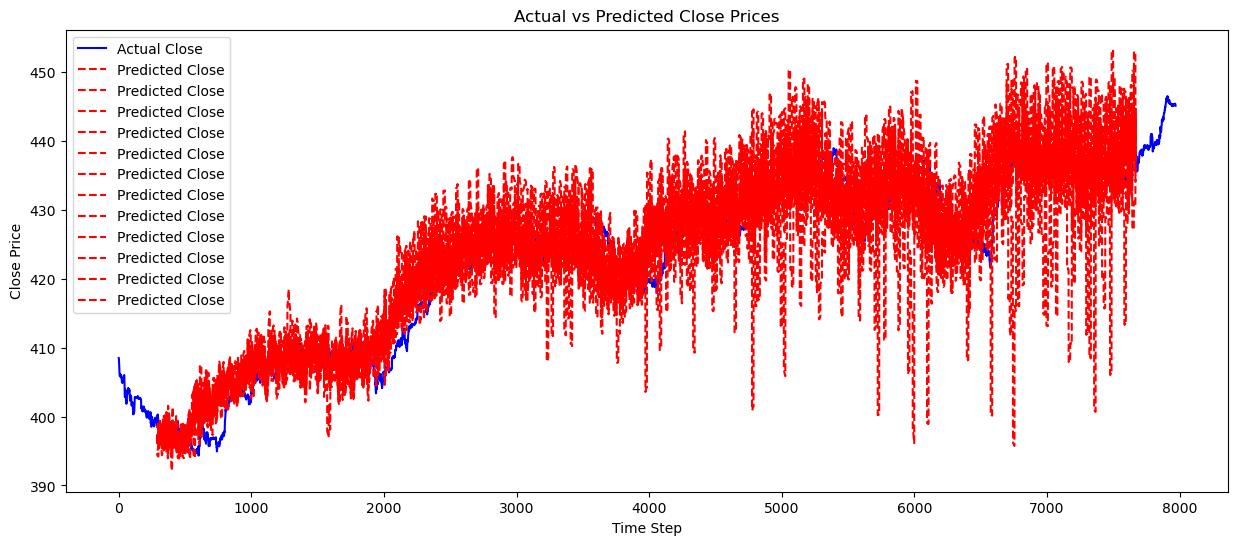

In [110]:
import matplotlib.pyplot as plt

# 假设df是您的DataFrame，并且包含名为'close'的列，其中包含实际的收盘价
# 假设predictions已经通过适当的逆缩放处理

# 逆缩放预测值


# 计算预测值在时间序列中的起始点
start_point = time_step

# 绘制实际的close值
plt.figure(figsize=(15, 6))
plt.plot(df['close'].values, label='Actual Close', color='blue')

# 绘制预测的close值，从start_point开始
plt.plot(range(start_point, start_point + len(y_pred_rescaled_flat)), y_pred_rescaled_flat, label='Predicted Close', linestyle='--', color='red')

plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [112]:
y_pred_rescaled_flat.shape

(7384, 12)

In [113]:
len(df['close'])

7971

# 增量预测

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 假设 df 是您的 DataFrame

# 数据准备
features = df.drop(['close', 'time', 'open', 'high', 'low'], axis=1)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_label = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_label.fit_transform(df[['close']])
scaled_features = np.hstack((scaled_features, scaled_close))


time_step=96*3

future_step=12

from keras import backend as K



# 修改create_dataset函数，以支持滚动预测
def create_dataset(data, start_index, end_index, time_step, future_step):
    X, Y = [], []
    if end_index is None:
        end_index = len(data) - future_step
    for i in range(start_index, end_index):
        end_ix = i + time_step
        out_end_ix = end_ix + future_step
        if out_end_ix > len(data):
            break
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix:out_end_ix, -1]
        X.append(seq_x)
        Y.append(seq_y)
    return np.array(X), np.array(Y)

# 初始化模型结构
def build_model(input_shape, output_units):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape, kernel_initializer='glorot_uniform'),
        LSTM(50),
        Dense(output_units)
    ])
    return model

# 全局模型初始化
model = build_model((time_step, scaled_features.shape[1]-1), future_step)
optimizer = Adam(learning_rate=0.001, clipvalue=0.5)
model.compile(optimizer=optimizer, loss=custom_loss)


# 自定义加权损失函数
def custom_loss(y_true, y_pred):
    weights = K.arange(1, K.shape(y_true)[-1] + 1, dtype=K.floatx())
    mse = K.square(y_pred - y_true)
    weighted_mse = mse * weights
    return K.mean(weighted_mse, axis=-1)

# 初始训练（可选）
initial_training_size = int(len(scaled_features) * 0.8)  # 假设使用80%的数据进行初始训练
initial_epochs = 20  # 初始训练的epoch数

# 对模型进行初始训练
X_init, y_init = create_dataset(scaled_features, 0, initial_training_size, time_step, future_step)
model.fit(X_init, y_init, epochs=initial_epochs, batch_size=64, verbose=1)


# 滚动预测与增量学习
predictions = []
n_records = len(scaled_features)

incremental_epochs = 5  # 增量学习阶段的epoch数减少
for i in range(initial_training_size, n_records - time_step, future_step):
    print(f"Processing window: {i} to {i + time_step}")
    X_train, y_train = create_dataset(scaled_features, i, i + time_step, time_step, future_step)
    
    # 适用于增量学习的训练
    if len(X_train) > 0:
        model.fit(X_train, y_train, epochs=incremental_epochs, batch_size=64, verbose=1)
        
        # 预测未来数据点
        X_pred, _ = create_dataset(scaled_features, i + time_step, i + time_step + future_step, time_step, future_step)
        if len(X_pred) > 0:
            y_pred = model.predict(X_pred)
            predictions.append(y_pred)


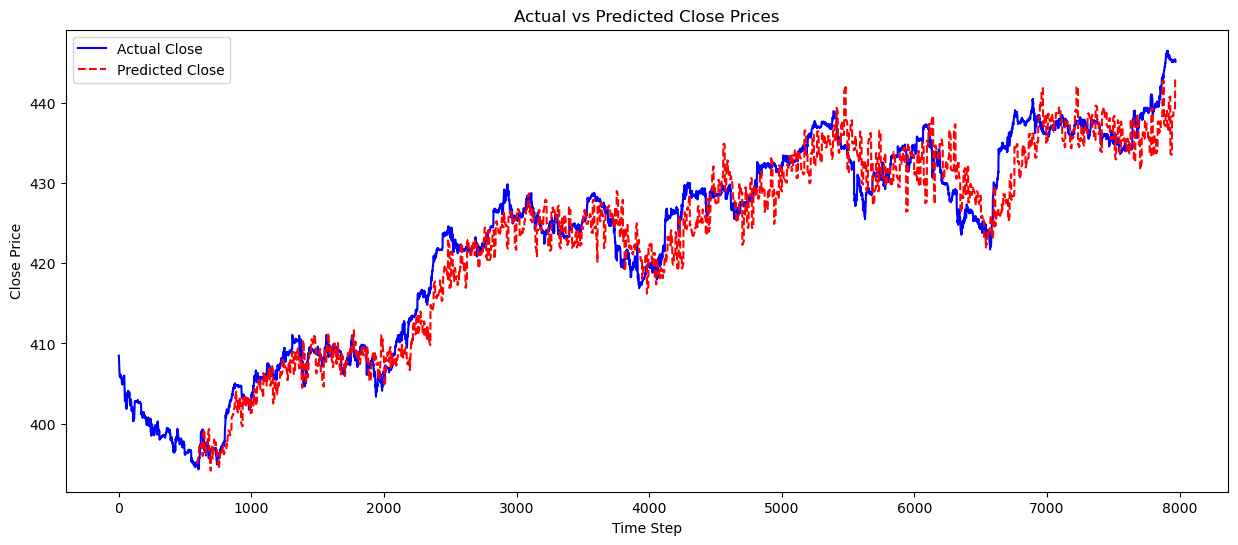

# 计算回报

In [34]:
# 假设已经完成模型训练和预测步骤

# 逆标准化预测结果
y_pred_rescaled = scaler_label.inverse_transform(y_pred)
y_test_rescaled = scaler_label.inverse_transform(y_test)

# 由于预测结果对应于测试集，我们需要确定测试集开始的索引
test_start_index = len(df) - len(y_pred_rescaled)

# 创建一个新列以存储预测结果
# 注意：这里我们简化地只存储未来一个小时预测的最后一个值


predicted_close = np.full(shape=len(df), fill_value=np.nan)
predicted_close[test_start_index:] = y_pred_rescaled[:,-1]  # 只考虑每个序列预测的最后一个值

actual_close = np.full(shape=len(df), fill_value=np.nan)
# 为了对齐预测值，我们从测试集开始的索引处填充真实的关闭价格
# 注意，我们这里也是只考虑每个序列预测的最后一个值，因为这代表了一小时后的真实close值
actual_close[test_start_index:] = y_test_rescaled[:,-1]  # 只考虑每个序列的最后一个值

# 将真实的close值加入到df中
df['actual_close_in1h'] = actual_close

df['predicted_close_in1h'] = predicted_close


In [35]:
df_1h_magnify = df[['close','actual_close_in1h','predicted_close_in1h']]

In [36]:
df_1h_magnify['true_updown_in1h'] = df_1h_magnify['actual_close_in1h']/df_1h_magnify['close'] - 1
df_1h_magnify['predict_updown_in1h'] = df_1h_magnify['predicted_close_in1h']/df_1h_magnify['close'] - 1

/var/folders/t2/vmnkmyxs42b6h_fbsdjtsp0c0000gn/T/ipykernel_36048/2636791147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1h_magnify['true_updown_in1h'] = df_1h_magnify['actual_close_in1h']/df_1h_magnify['close'] - 1
/var/folders/t2/vmnkmyxs42b6h_fbsdjtsp0c0000gn/T/ipykernel_36048/2636791147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1h_magnify['predict_updown_in1h'] = df_1h_magnify['predicted_close_in1h']/df_1h_magnify['close'] - 1


In [37]:
df_1h_magnify = df_1h_magnify.dropna(how='any')

df_1h_magnify['direction_same'] = (df_1h_magnify['true_updown_in1h'] * df_1h_magnify['predict_updown_in1h']) > 0

# 计算方向相同的次数
direction_same_count = df_1h_magnify['direction_same'].sum()

direction_same_count/len(df_1h_magnify)

0.5322475570032573

In [38]:
df_1h_magnify['true_updown_in1h'].quantile(0.25)

-0.00029383574733743423

In [39]:
df_1h_magnify['true_updown_in1h'].quantile(0.75)

0.0002091247577915567

In [40]:
df_1h_magnify

,close,actual_close_in1h,predicted_close_in1h,true_updown_in1h,predict_updown_in1h,direction_same
Date,,,,,,
2024-02-20 19:20:00,426.5100,426.3200,426.312683,-0.000445,-0.000463,True
2024-02-20 19:25:00,426.4799,426.5100,426.419159,0.000071,-0.000142,False
2024-02-20 19:30:00,426.3400,426.4799,426.467346,0.000328,0.000299,True
2024-02-20 19:35:00,426.3000,426.3400,426.333466,0.000094,0.000079,True
2024-02-20 19:40:00,426.2800,426.3000,426.067139,0.000047,-0.000499,False
...,...,...,...,...,...,...
2024-03-01 19:35:00,445.3900,445.4000,442.235260,0.000022,-0.007083,False
2024-03-01 19:40:00,445.4000,445.3900,442.167419,-0.000022,-0.007258,True
2024-03-01 19:45:00,445.3500,445.4000,441.949524,0.000112,-0.007636,False


# 模型表现

In [41]:
#config

buy_threshold = 0.0002
sell_threshold = -0.0003

In [42]:
# 初始化资金和仓位
initial_capital = 1000
capital = initial_capital
position = 0  # 当前仓位，正数为持有，负数为卖空
trade_count = 0  # 交易次数
waiting_period = 0  # 等待期间的计数器
capital_list = []

for index, row in df_1h_magnify.iterrows():
    predict_change_rate = row['predict_updown_in1h']
    
    # 如果在等待期间
    if waiting_period > 0:
        waiting_period -= 1
        # 检查是否有相反的信号出现
        if (position > 0 and predict_change_rate < sell_threshold) or (position < 0 and predict_change_rate > buy_threshold):
            # 平仓
            capital += position * row['close']
            position = 0  # 清仓
            waiting_period = 0  # 重置等待期间
            
    # 检查是否买入条件
    if position == 0 and predict_change_rate > buy_threshold:
        # 买入
        position = 100 / row['close']
        capital -= position * row['close']
        waiting_period = 11  # 设置等待期间
        trade_count += 1
    elif position == 0 and predict_change_rate < sell_threshold:
        # 卖空
        position = -100 / row['close']
        capital += abs(position) * row['close']
        waiting_period = 11
        trade_count += 1
        
    # 如果不在等待期间，则可以平仓
    if waiting_period == 0 and position != 0:
        capital += position * row['close']
        position = 0  # 清仓

    

    # 检查是否是DataFrame的最后一行
    if index == df_1h_magnify.index[-1] and position != 0:
        # 如果是最后一期，则关闭所有仓位
        capital += position * row['close']
        position = 0  # 清仓
    capital_list.append(capital)

# 计算总回报
total_return = capital - initial_capital
df_1h_magnify['capital_list'] = capital_list

In [43]:
total_return

-0.8239363252265548

In [44]:
df_1h_magnify['capital_list'][-1]/1000-1

-0.000823936325226593

In [45]:
df_1h_magnify['close'][-1]/df_1h_magnify['close'][0] -1

0.043586316850718676

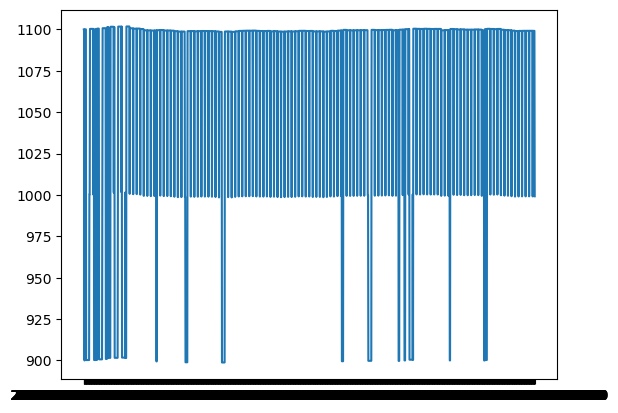

In [46]:
plt.plot(df_1h_magnify.index,df_1h_magnify['capital_list'])

In [47]:
capital_list

[1100.0,
 1100.0,
 900.0398583855009,
 900.0398583855009,
 1100.0257851106498,
 1100.0257851106498,
 1100.0257851106498,
 1100.0257851106498,
 900.2627185816079,
 900.2627185816079,
 900.2627185816079,
 900.2627185816079,
 900.2627185816079,
 900.2627185816079,
 900.2627185816079,
 900.2627185816079,
 900.2627185816079,
 900.2627185816079,
 900.2627185816079,
 1000.3050446332927,
 1000.3050446332927,
 1100.3050446332927,
 1100.3050446332927,
 1100.3050446332927,
 1100.3050446332927,
 1100.3050446332927,
 1100.3050446332927,
 1100.3050446332927,
 1100.3050446332927,
 1100.3050446332927,
 1100.3050446332927,
 1100.3050446332927,
 1000.2838890693794,
 1100.2838890693793,
 1100.2838890693793,
 900.2697777309188,
 900.2697777309188,
 900.2697777309188,
 900.2697777309188,
 900.2697777309188,
 900.2697777309188,
 1100.3026054793022,
 1100.3026054793022,
 900.3706842475655,
 900.3706842475655,
 900.3706842475655,
 1100.464779754505,
 1100.464779754505,
 1100.464779754505,
 1100.464779754505,
